In [1]:
# imports
import numpy as np
import plotly.express as px
import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import math
df = pd.read_csv('online_shoppers_intention.csv', na_values=['NA', 'null', '', 'NULL'])

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AffinityPropagation, DBSCAN, Birch

In [3]:
df_num = df.copy()

num_var = [
    'Administrative',
    'Administrative_Duration',
    'Informational',
    'Informational_Duration',
    'ProductRelated',
    'ProductRelated_Duration',
    'BounceRates',
    'ExitRates',
    'PageValues',
    'SpecialDay'
]

df_num = df_num[num_var]
print(df_num.head())


   Administrative  Administrative_Duration  Informational  \
0               0                      0.0              0   
1               0                      0.0              0   
2               0                      0.0              0   
3               0                      0.0              0   
4               0                      0.0              0   

   Informational_Duration  ProductRelated  ProductRelated_Duration  \
0                     0.0               1                 0.000000   
1                     0.0               2                64.000000   
2                     0.0               1                 0.000000   
3                     0.0               2                 2.666667   
4                     0.0              10               627.500000   

   BounceRates  ExitRates  PageValues  SpecialDay  
0         0.20       0.20         0.0         0.0  
1         0.00       0.10         0.0         0.0  
2         0.20       0.20         0.0         0.0  
3   

In [4]:
# PCA using only numerical variables 
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_num_scaled = scaler.fit_transform(df_num)
df_num_scaled = pd.DataFrame(df_num_scaled, columns=df_num.columns)

from sklearn.decomposition import PCA

pca = PCA(n_components=5)
df_num_pca = pca.fit_transform(df_num_scaled)

df_num_pca = pd.DataFrame(data=df_num_pca, columns=['Principal Component 1', 'Principal Component 2', 'Principal Component 3', 'Principal Component 4', 'Principal Component 5'])
explained_variance = pca.explained_variance_ratio_
print("Explained variance for each component:", explained_variance)
print("Total explained variance:", explained_variance.sum())

Explained variance for each component: [0.3400384  0.16751818 0.10712928 0.10107608 0.09410784]
Total explained variance: 0.8098697731898978


In [5]:

df_comb = df[['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 
              'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates',  'PageValues', 
              'SpecialDay', 'Month', 'VisitorType', 'Weekend', 'Revenue']].copy()

# Encoding categorical variables
label_encoder = LabelEncoder()
df_comb['Month'] = label_encoder.fit_transform(df_comb['Month'])
df_comb['VisitorType'] = label_encoder.fit_transform(df_comb['VisitorType'])
df_comb['Weekend'] = df_comb['Weekend'].astype(int)  
df_comb['Revenue'] = df_comb['Revenue'].astype(int) 

# Standardizing the data for PCA
scaler = StandardScaler()
# Select only numeric columns for scaling
numeric_cols = df_comb.drop(columns=['Month', 'VisitorType', 'Weekend', 'Revenue']).columns
df_comb_scaled = scaler.fit_transform(df_comb[numeric_cols])
df_comb_scaled = pd.DataFrame(df_comb_scaled, columns=numeric_cols)

# Combine scaled data with encoded categorical variables
df_comb_scaled = pd.concat([df_comb_scaled, df_comb[['Month', 'VisitorType', 'Weekend', 'Revenue']].reset_index(drop=True)], axis=1)

# Performing PCA
pca = PCA(n_components=5)
df_comb_pca = pca.fit_transform(df_comb_scaled)

# Creating a DataFrame for PCA results
df_comb_pca = pd.DataFrame(data=df_comb_pca, columns=['Principal Component 1', 'Principal Component 2', 'Principal Component 3', 'Principal Component 4', 'Principal Component 5'])

# Explained variance
explained_variance = pca.explained_variance_ratio_
print("Explained variance for each component:", explained_variance)
print("Total explained variance:", explained_variance.sum())


Explained variance for each component: [0.34500864 0.20599292 0.10428625 0.06624012 0.06162944]
Total explained variance: 0.7831573686052664


From all the PCA we can conclude that not all the categorical variables maybe so relevant

NOW LET'S RUN THE CLUSTERING METHODS 

In [6]:
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import DBSCAN
from sklearn.cluster import Birch


Number of clusters found by DBSCAN: 29


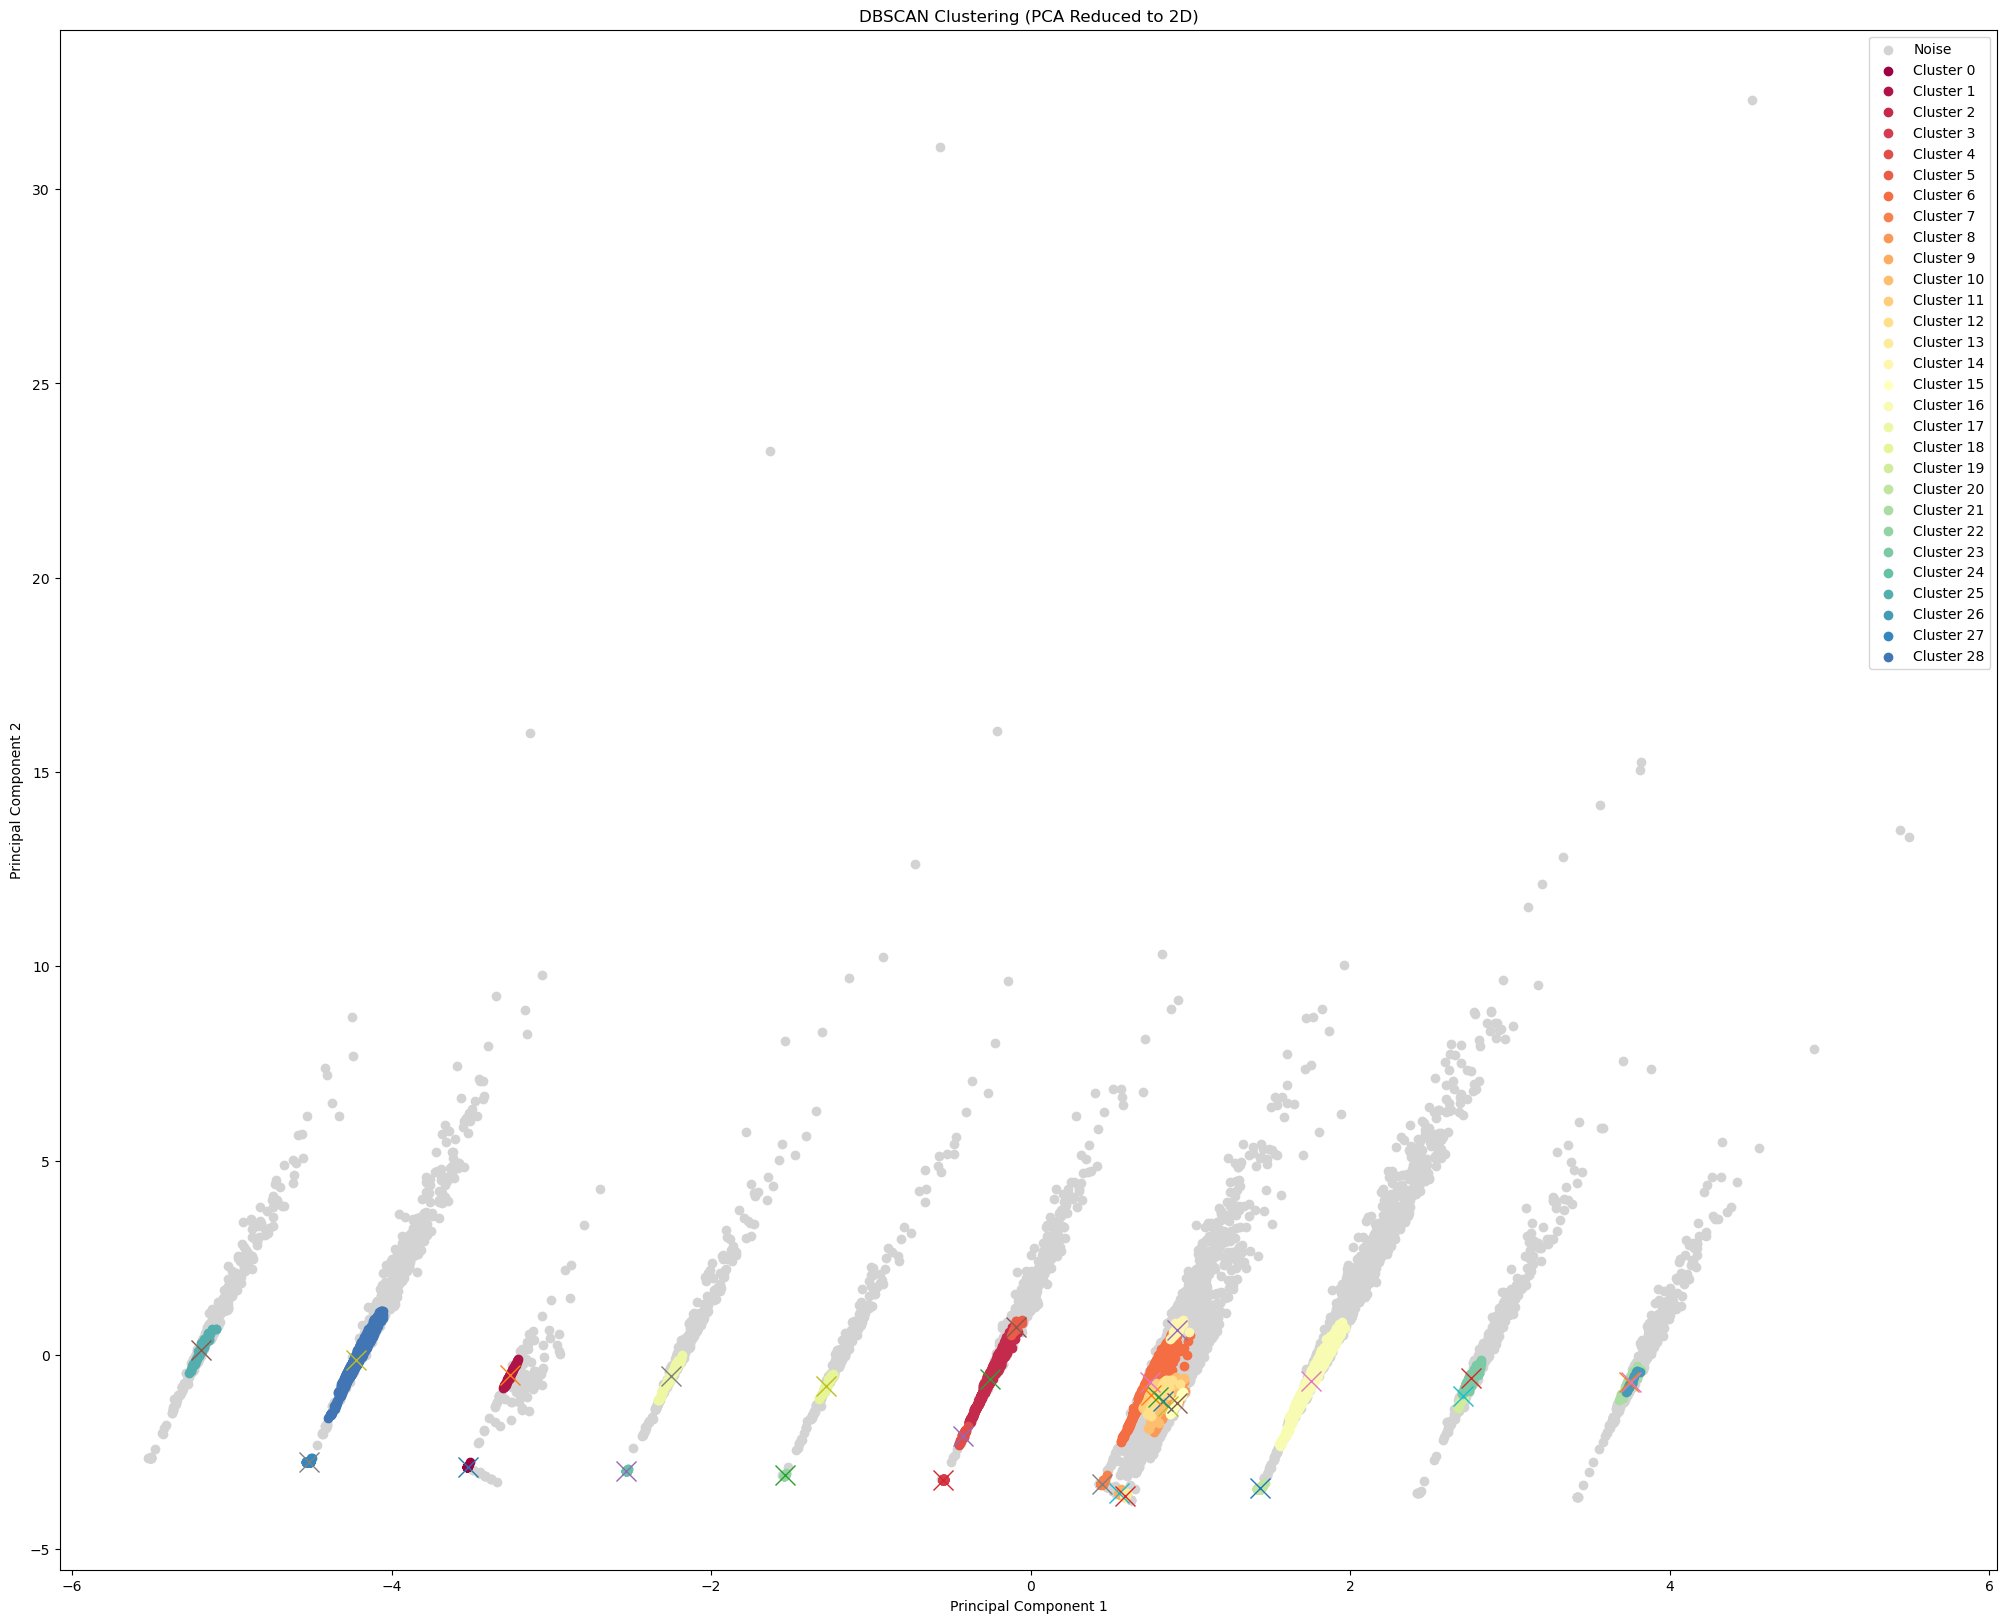

In [8]:
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

# Sample the data from df_num_pca
# sample_df = df_num_pca.sample(n=2000, random_state=42).reset_index(drop=True)

# Apply DBSCAN
dbscan = DBSCAN(eps=0.3, min_samples=15)
dbscan_labels = dbscan.fit_predict(df_num_pca)

# Number of clusters found (excluding noise)
dbscan_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
print(f"Number of clusters found by DBSCAN: {dbscan_clusters}")

# Use the first two principal components from df_num_pca for visualization
dbscan_pca = df_num_pca[['Principal Component 1', 'Principal Component 2']].values

# Plot the clusters
plt.figure(figsize=(25, 20))
# for k in set(dbscan_labels):
#     color = 'k' if k == -1 else plt.cm.Spectral(k / (dbscan_clusters + 1))  
#     plt.scatter(dbscan_pca[dbscan_labels == k, 0], dbscan_pca[dbscan_labels == k, 1], color=color, label=f'Cluster {k}' if k != -1 else 'Noise')


noise_color = 'lightgray'
plt.scatter(dbscan_pca[dbscan_labels == -1, 0], dbscan_pca[dbscan_labels == -1, 1], color=noise_color, label='Noise')

for k in set(dbscan_labels):
    if k != -1:  # Skip noise
        color = plt.cm.Spectral(k / (dbscan_clusters + 1))
        plt.scatter(dbscan_pca[dbscan_labels == k, 0], dbscan_pca[dbscan_labels == k, 1], color=color, label=f'Cluster {k}')

# Calculate and show cluster centroids using a black cross (X)
cluster_centers = []
for k in set(dbscan_labels):
    if k != -1:  # Skip noise
        cluster_center = dbscan_pca[dbscan_labels == k].mean(axis=0)
        cluster_centers.append(cluster_center)
        plt.plot(cluster_center[0], cluster_center[1], 'x', markersize=15)

# Final plot additions
plt.title('DBSCAN Clustering (PCA Reduced to 2D)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


Number of clusters found by BIRCH: 93


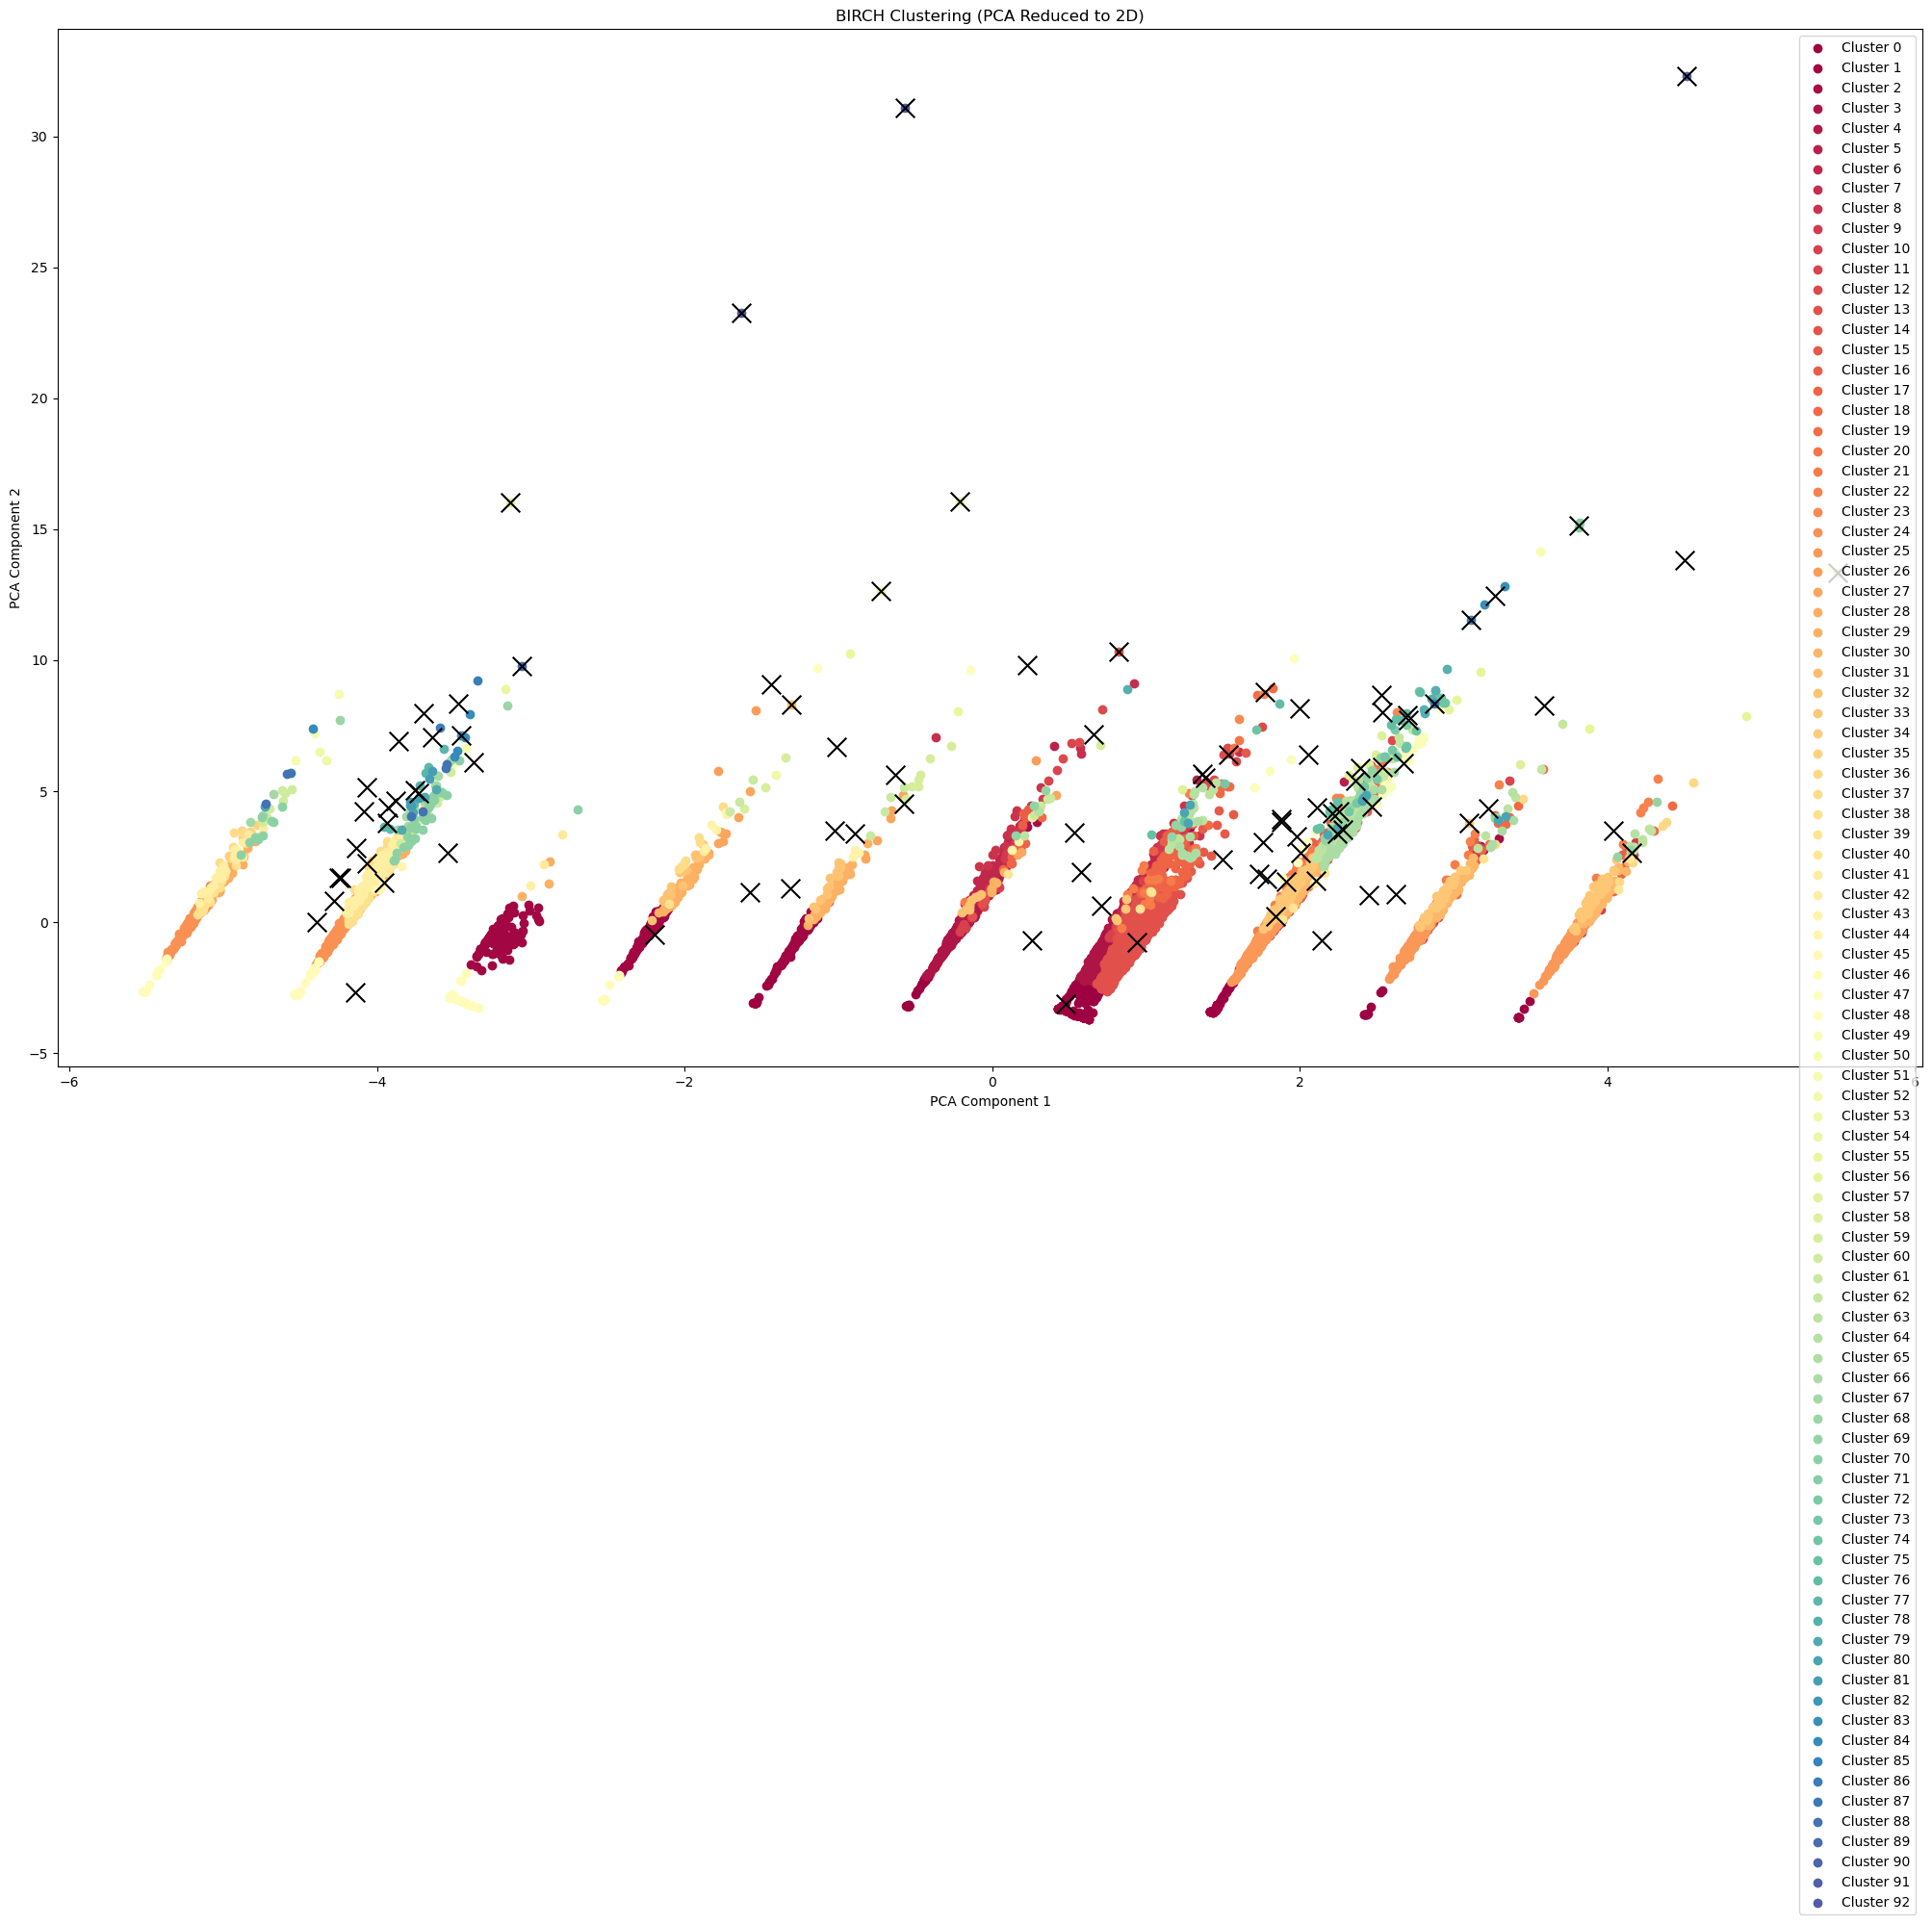

In [9]:

# Apply BIRCH
birch = Birch(n_clusters=None, threshold=2)  # Set n_clusters to None for no fixed number, threshold is the radius of the subcluster
birch_labels = birch.fit_predict(df_num_pca)

# Number of clusters found (excluding noise)
birch_clusters = len(set(birch_labels)) - (1 if -1 in birch_labels else 0)
print(f"Number of clusters found by BIRCH: {birch_clusters}")


# Reduce to 2 dimensions using PCA for visualization
birch_pca = PCA(n_components=2).fit_transform(df_num_pca)

# Plot the clusters
plt.figure(figsize=(25, 14))
for k in set(birch_labels):
    color = 'k' if k == -1 else plt.cm.Spectral(k / (birch_clusters + 1))  # Color for noise or other clusters
    plt.scatter(birch_pca[birch_labels == k, 0], birch_pca[birch_labels == k, 1], color=color, label=f'Cluster {k}' if k != -1 else 'Noise')

# Calculate and show cluster centroids using a black cross (X)
for k in set(birch_labels):
    if k != -1:  # Skip noise
        cluster_points = birch_pca[birch_labels == k]  # Points in the k-th cluster
        cluster_centroid = np.mean(cluster_points, axis=0)  # Calculate centroid
        plt.scatter(cluster_centroid[0], cluster_centroid[1], s=200, c='black', marker='x')

# Final plot additions
plt.title('BIRCH Clustering (PCA Reduced to 2D)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()


Number of clusters found by Affinity Propagation: 93


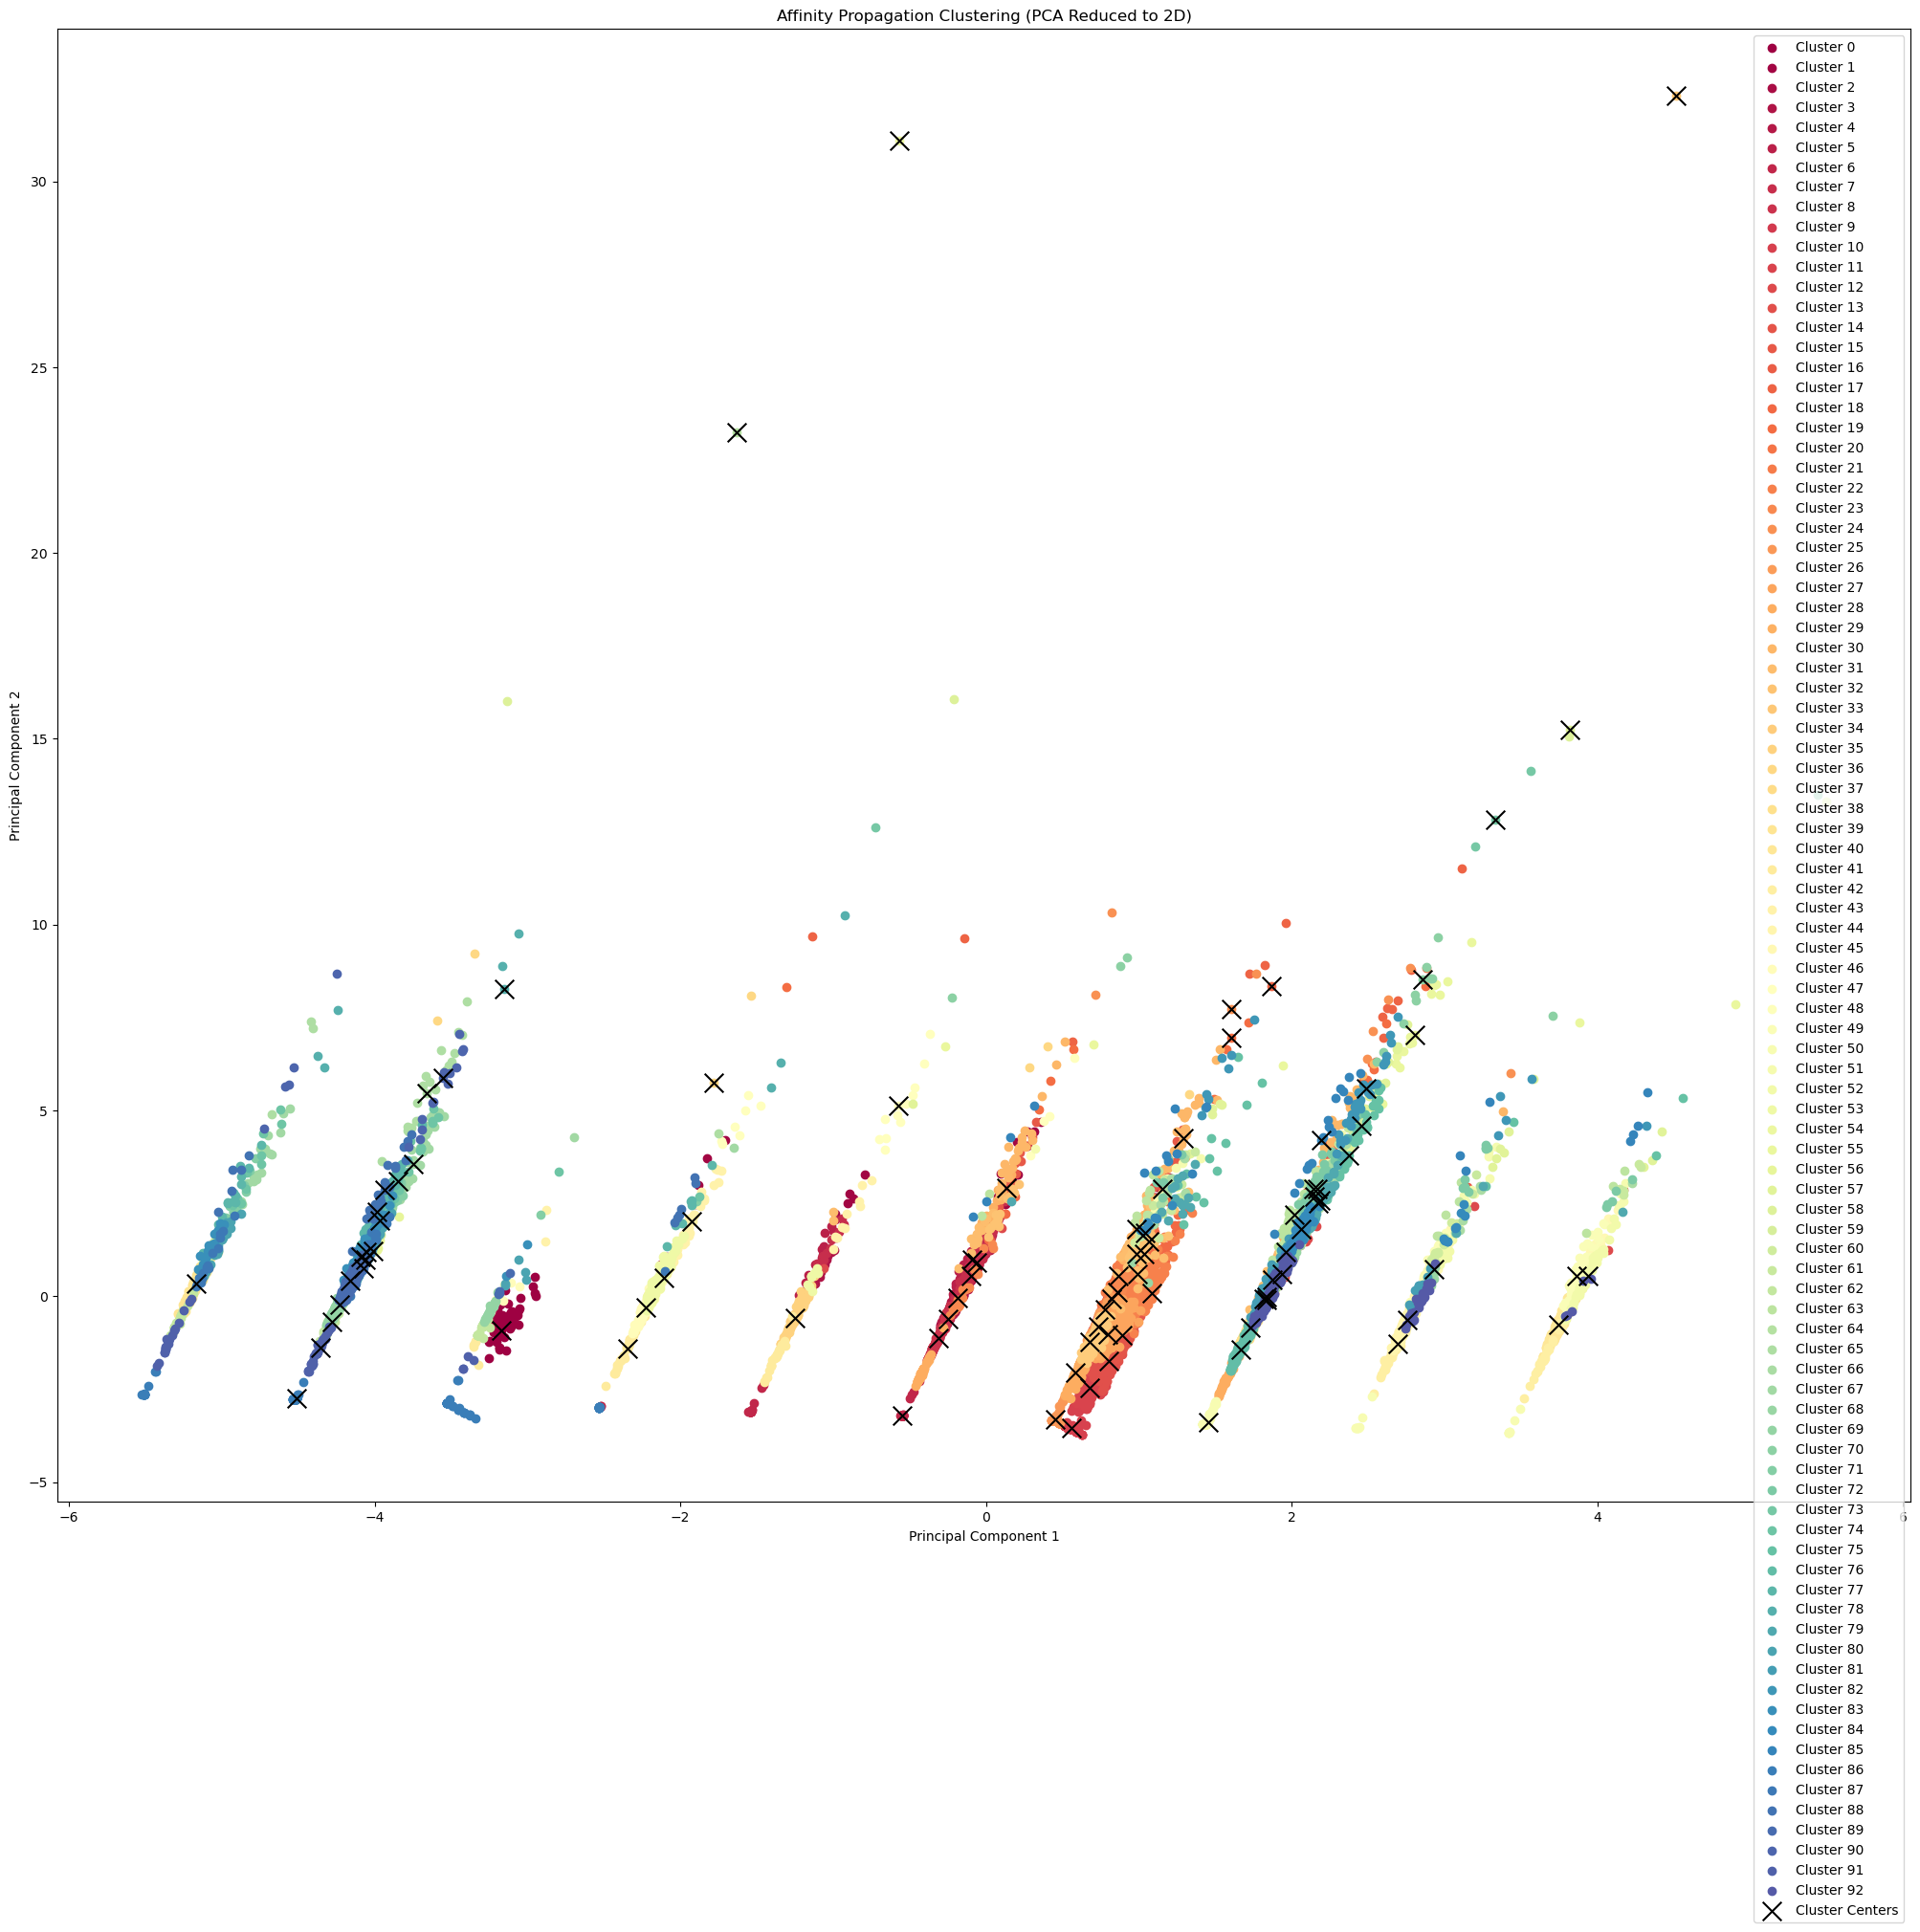

In [10]:
# Assuming you have already created df_num_pca using PCA
# Sample the data
# sample_df = df_num_pca.sample(n=2000, random_state=42).reset_index(drop=True)

# Apply Affinity Propagation
from sklearn.cluster import AffinityPropagation
afprop = AffinityPropagation(preference=-75, max_iter=500, damping=0.9, random_state=5)
afprop_labels = afprop.fit_predict(df_num_pca)

# Number of clusters found (excluding noise)
afprop_clusters = len(set(afprop_labels)) - (1 if -1 in afprop_labels else 0)
print(f"Number of clusters found by Affinity Propagation: {afprop_clusters}")

# Reduce to 2 dimensions using PCA for visualization (already reduced in df_num_pca)
# Selecting the first two principal components for visualization
afprop_pca = df_num_pca[['Principal Component 1', 'Principal Component 2']].values

# Plot the clusters
import matplotlib.pyplot as plt

plt.figure(figsize=(25, 20))
for k in set(afprop_labels):
    color = 'k' if k == -1 else plt.cm.Spectral(k / (afprop_clusters + 1))  # Color for noise or other clusters
    plt.scatter(afprop_pca[afprop_labels == k, 0], afprop_pca[afprop_labels == k, 1], color=color, label=f'Cluster {k}' if k != -1 else 'Noise')

# Show the cluster centers
cluster_centers_indices = afprop.cluster_centers_indices_
if cluster_centers_indices is not None:
    cluster_centers = afprop.cluster_centers_
    plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], s=200, c='black', marker='x', label='Cluster Centers')

# Final plot additions
plt.title('Affinity Propagation Clustering (PCA Reduced to 2D)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


In [ ]:
# Use Sklearn's Davies Bouldin Score to evaluate the results of all clustering models
from sklearn.metrics import davies_bouldin_score

db_score_afprop = davies_bouldin_score(df_num_pca, afprop_labels)
print(f"Davies-Bouldin Score for Affinity Propagation: {db_score_afprop}")

db_score_dbscan = davies_bouldin_score(df_num_pca, dbscan_labels)
print(f"Davies-Bouldin Score for DBSCAN: {db_score_dbscan}")

db_score_birch = davies_bouldin_score(df_num_pca, birch_labels)
print(f"Davies-Bouldin Score for BIRCH: {db_score_birch}")

# Use Sklearn's Calinski-Harabasz Index to evaluate the results of all clustering models.
from sklearn.metrics import calinski_harabasz_score

ch_score_afprop = calinski_harabasz_score(df_num_pca, afprop_labels)
print(f"\nCalinski-Harabasz Index for Affinity Propagation: {ch_score_afprop}")

ch_score_dbscan = calinski_harabasz_score(df_num_pca, dbscan_labels)
print(f"Calinski-Harabasz Index for DBSCAN: {ch_score_dbscan}")

ch_score_birch = calinski_harabasz_score(df_num_pca, birch_labels)
print(f"Calinski-Harabasz Index for BIRCH: {ch_score_birch}")

